**Students**: Kerim Kochekov, Utkarsh Kalra

**Original model:**
Max_answer_caption_length = 20

Encoder: Used Resnet152(just deleting last layer to get FC 2048 sized layer) -> Linear (2048, 256) -> BatchNormalization(Linear())

Decoder: Embedding(vocabulary_size, 256) -> LSTM(embedding_size=256, hidden_size=512, number_of_layers = 1)

Strategy for predict(caption generate): Greedy-strategy (get maximum)

**Our version:** Max_answer_caption_length = 15

Encoder: Used Resnet50(just deleting last layer to get FC 2048 sized layer) -> Linear1 (2048, 512) -> Dropput(p=0.2) -> Linear2 (512, 256) 

Decoder: Embedding(vocabulary_size, 256) -> LSTM(embedding_size=256, hidden_size=512, number_of_layers = 2)

Strategy for predict(caption generate): Greedy-strategy (get maximum)

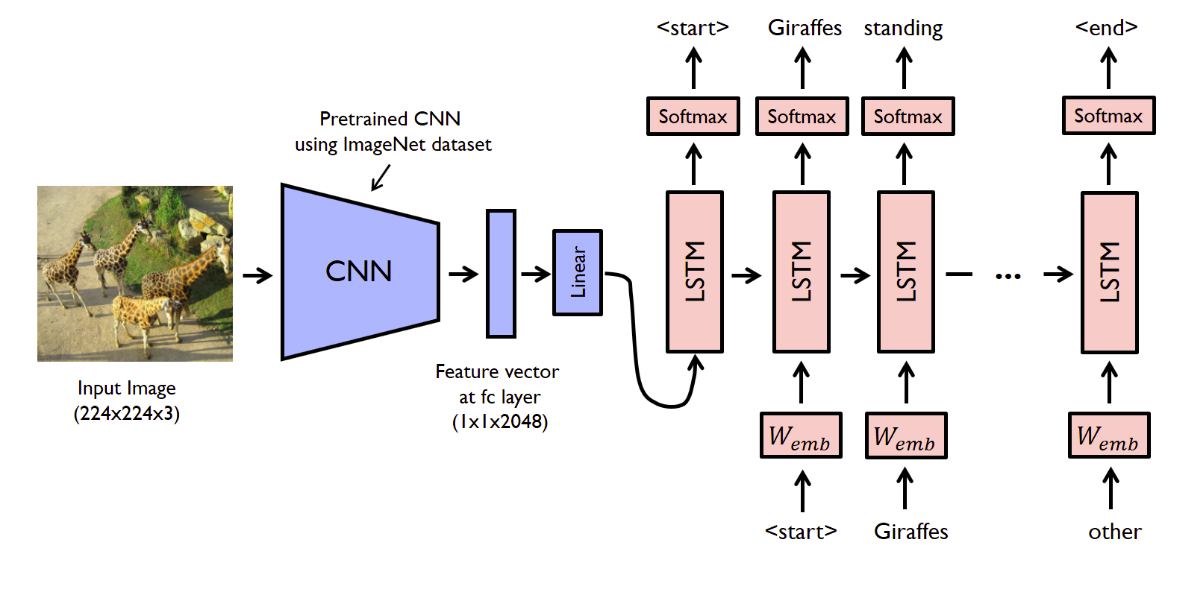

#Downloading MS-COCO

In [ ]:
  !mkdir data
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

!unzip ./data/captions_train-val2014.zip -d ./data/
!rm ./data/captions_train-val2014.zip
!unzip ./data/val2014.zip -d ./data/ 
!rm ./data/val2014.zip 


In [ ]:
import nltk
nltk.download('punkt')
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import os
from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Build Vocabulary

In [ ]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

vocab = build_vocab(json='/content/data/annotations/captions_train2014.json', threshold=4)
vocab_path = './data/vocab.pkl'

with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

#Resize images to constant 256x256 pixels

In [ ]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 1000 == 0:
            print ("[{}%] Resized the images and saved into '{}'.".format(int(100.0 * i / num_images), output_dir))

image_dir = '/content/data/train2014/'
output_dir = '/content/data/resized2014/'
image_size = [256, 256]
resize_images(image_dir, output_dir, image_size)

In [ ]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import torchvision.models as models
import torch.utils.data as data

#Model

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

#Data loader

In [ ]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

#Train Model

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model directory
if not os.path.exists('models/'):
    os.makedirs('models/')

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

# Build data loader
data_loader = get_loader('data/resized2014', 'data/annotations/captions_train2014.json', vocab,  transform, 128, shuffle=True, num_workers=2) 

# Build the models
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

# Train the models
total_step = len(data_loader)
for epoch in range(5): #Number of epochs
    for i, (images, captions, lengths) in enumerate(data_loader):
        
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 4, i, total_step, loss.item(), np.exp(loss.item()))) 
            
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder.state_dict(), os.path.join(
                'models/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                'models/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

FileNotFoundError: ignored